In [1]:
import sys
sys.path.append("/storage/vbutoi/projects/")
sys.path.append("/storage/vbutoi/libraries/")
from ionpy.analysis import ResultsLoader
import pathlib
import seaborn as sns
import pandas as pd
sns.set_context('talk')
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [2]:
path_list = [
    # "/storage/vbutoi/scratch/ESE/calibration/09_05_24_ISLES_TS",
    "/storage/vbutoi/scratch/ESE/calibration/09_05_24_ISLES_LTS",
]

df_list = []
for path in path_list:
    try:
        dfc = rs.load_configs(
            path,
            properties=False,
        )
        df = rs.load_metrics(dfc)
        df_list.append(df)
    except Exception as e:
        print(e)
df = pd.concat(df_list)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [3]:
# Only keep the epochs every 10 to reduce the number of points
df = df[df['epoch'] % 10 == 0]

In [4]:
for ikey in df.keys():
    print(ikey)

phase
epoch
loss
area_estimation_error
dice_score
ece_loss
data
iters_per_epoch
preload
train_splits
val_splits
version
batch_size
num_workers
pin_memory
seed
loss_func
batch_reduction
from_logits
model
filters
image_channels
img_channels
num_classes
optim
lr
base_checkpoint
base_pretrained_dir
base_pt_select_metric
epochs
eval_freq
path


In [5]:
def calibrator(path):
    if 'SVLS' in str(path):
        return 'SVLS'
    else:
        return 'None'
    
df.augment(calibrator)

In [6]:
df['path'].unique()

array([PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_05_24_ISLES_LTS/20240905_145632-R978-7d521dfe536cbc9d521c00515610ebf1'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_05_24_ISLES_LTS/20240905_145624-9O0P-0b2334ecd3674f1d01e8cff07ce54e07'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_05_24_ISLES_LTS/20240905_145628-XOL4-fc50a00816c1a7bcc08d6afe77813f7f'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_05_24_ISLES_LTS/20240905_150226-MLG9-5b6d45f0e17a5c742ccf5eb8dc041cc8'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_05_24_ISLES_LTS/20240905_150201-8AN0-242bf05ba4f473448b4f457eceb15c03'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_05_24_ISLES_LTS/20240905_145611-E60G-0bee91090514f6f6e3d3e89df75e7989'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_05_24_ISLES_LTS/20240905_150218-0PON-7df5e769bd9416dbf995525ef00361a2'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_0

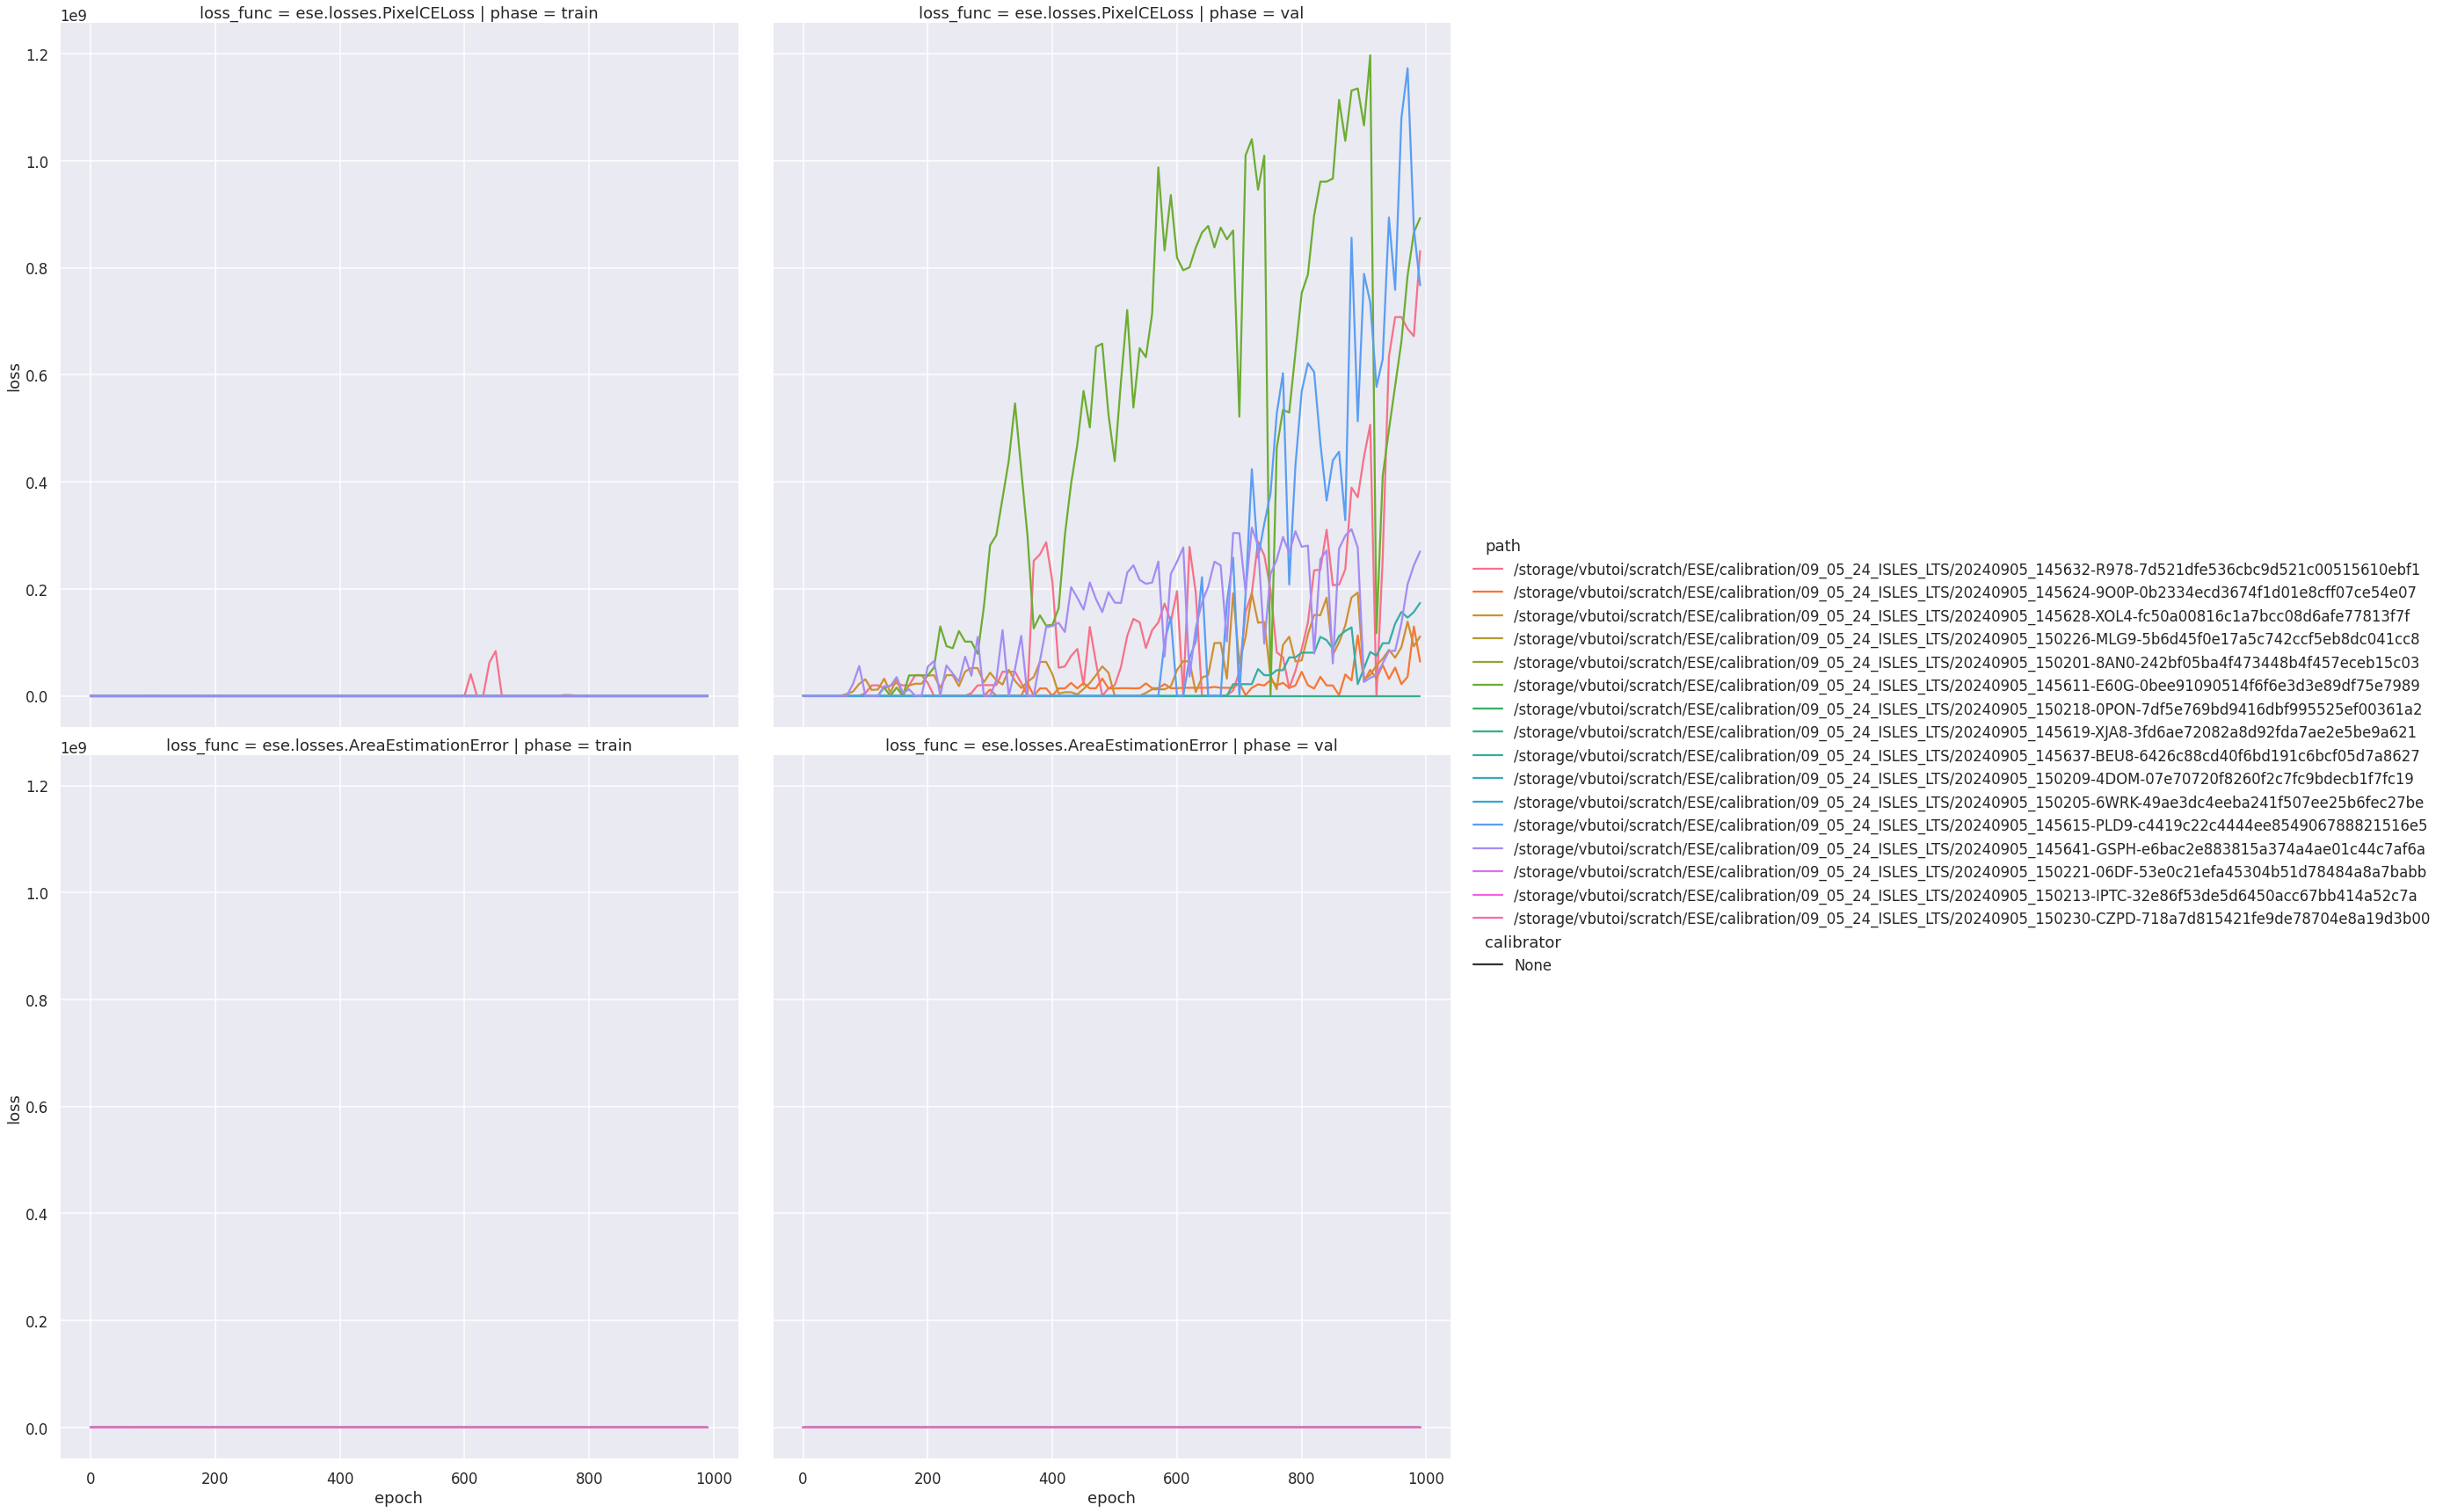

In [7]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='loss',
    hue='path',
    style='calibrator',   
    col='phase',
    row='loss_func',
    kind='line',
    height=12,
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.05)
# g.set(ylim=(0.0, 0.25))

In [8]:
df.select(loss_func='ese.losses.PixelCELoss')['path'].unique()

array([PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_05_24_ISLES_LTS/20240905_145632-R978-7d521dfe536cbc9d521c00515610ebf1'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_05_24_ISLES_LTS/20240905_145624-9O0P-0b2334ecd3674f1d01e8cff07ce54e07'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_05_24_ISLES_LTS/20240905_145628-XOL4-fc50a00816c1a7bcc08d6afe77813f7f'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_05_24_ISLES_LTS/20240905_145611-E60G-0bee91090514f6f6e3d3e89df75e7989'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_05_24_ISLES_LTS/20240905_145619-XJA8-3fd6ae72082a8d92fda7ae2e5be9a621'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_05_24_ISLES_LTS/20240905_145637-BEU8-6426c88cd40f6bd191c6bcf05d7a8627'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_05_24_ISLES_LTS/20240905_145615-PLD9-c4419c22c4444ee854906788821516e5'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_0

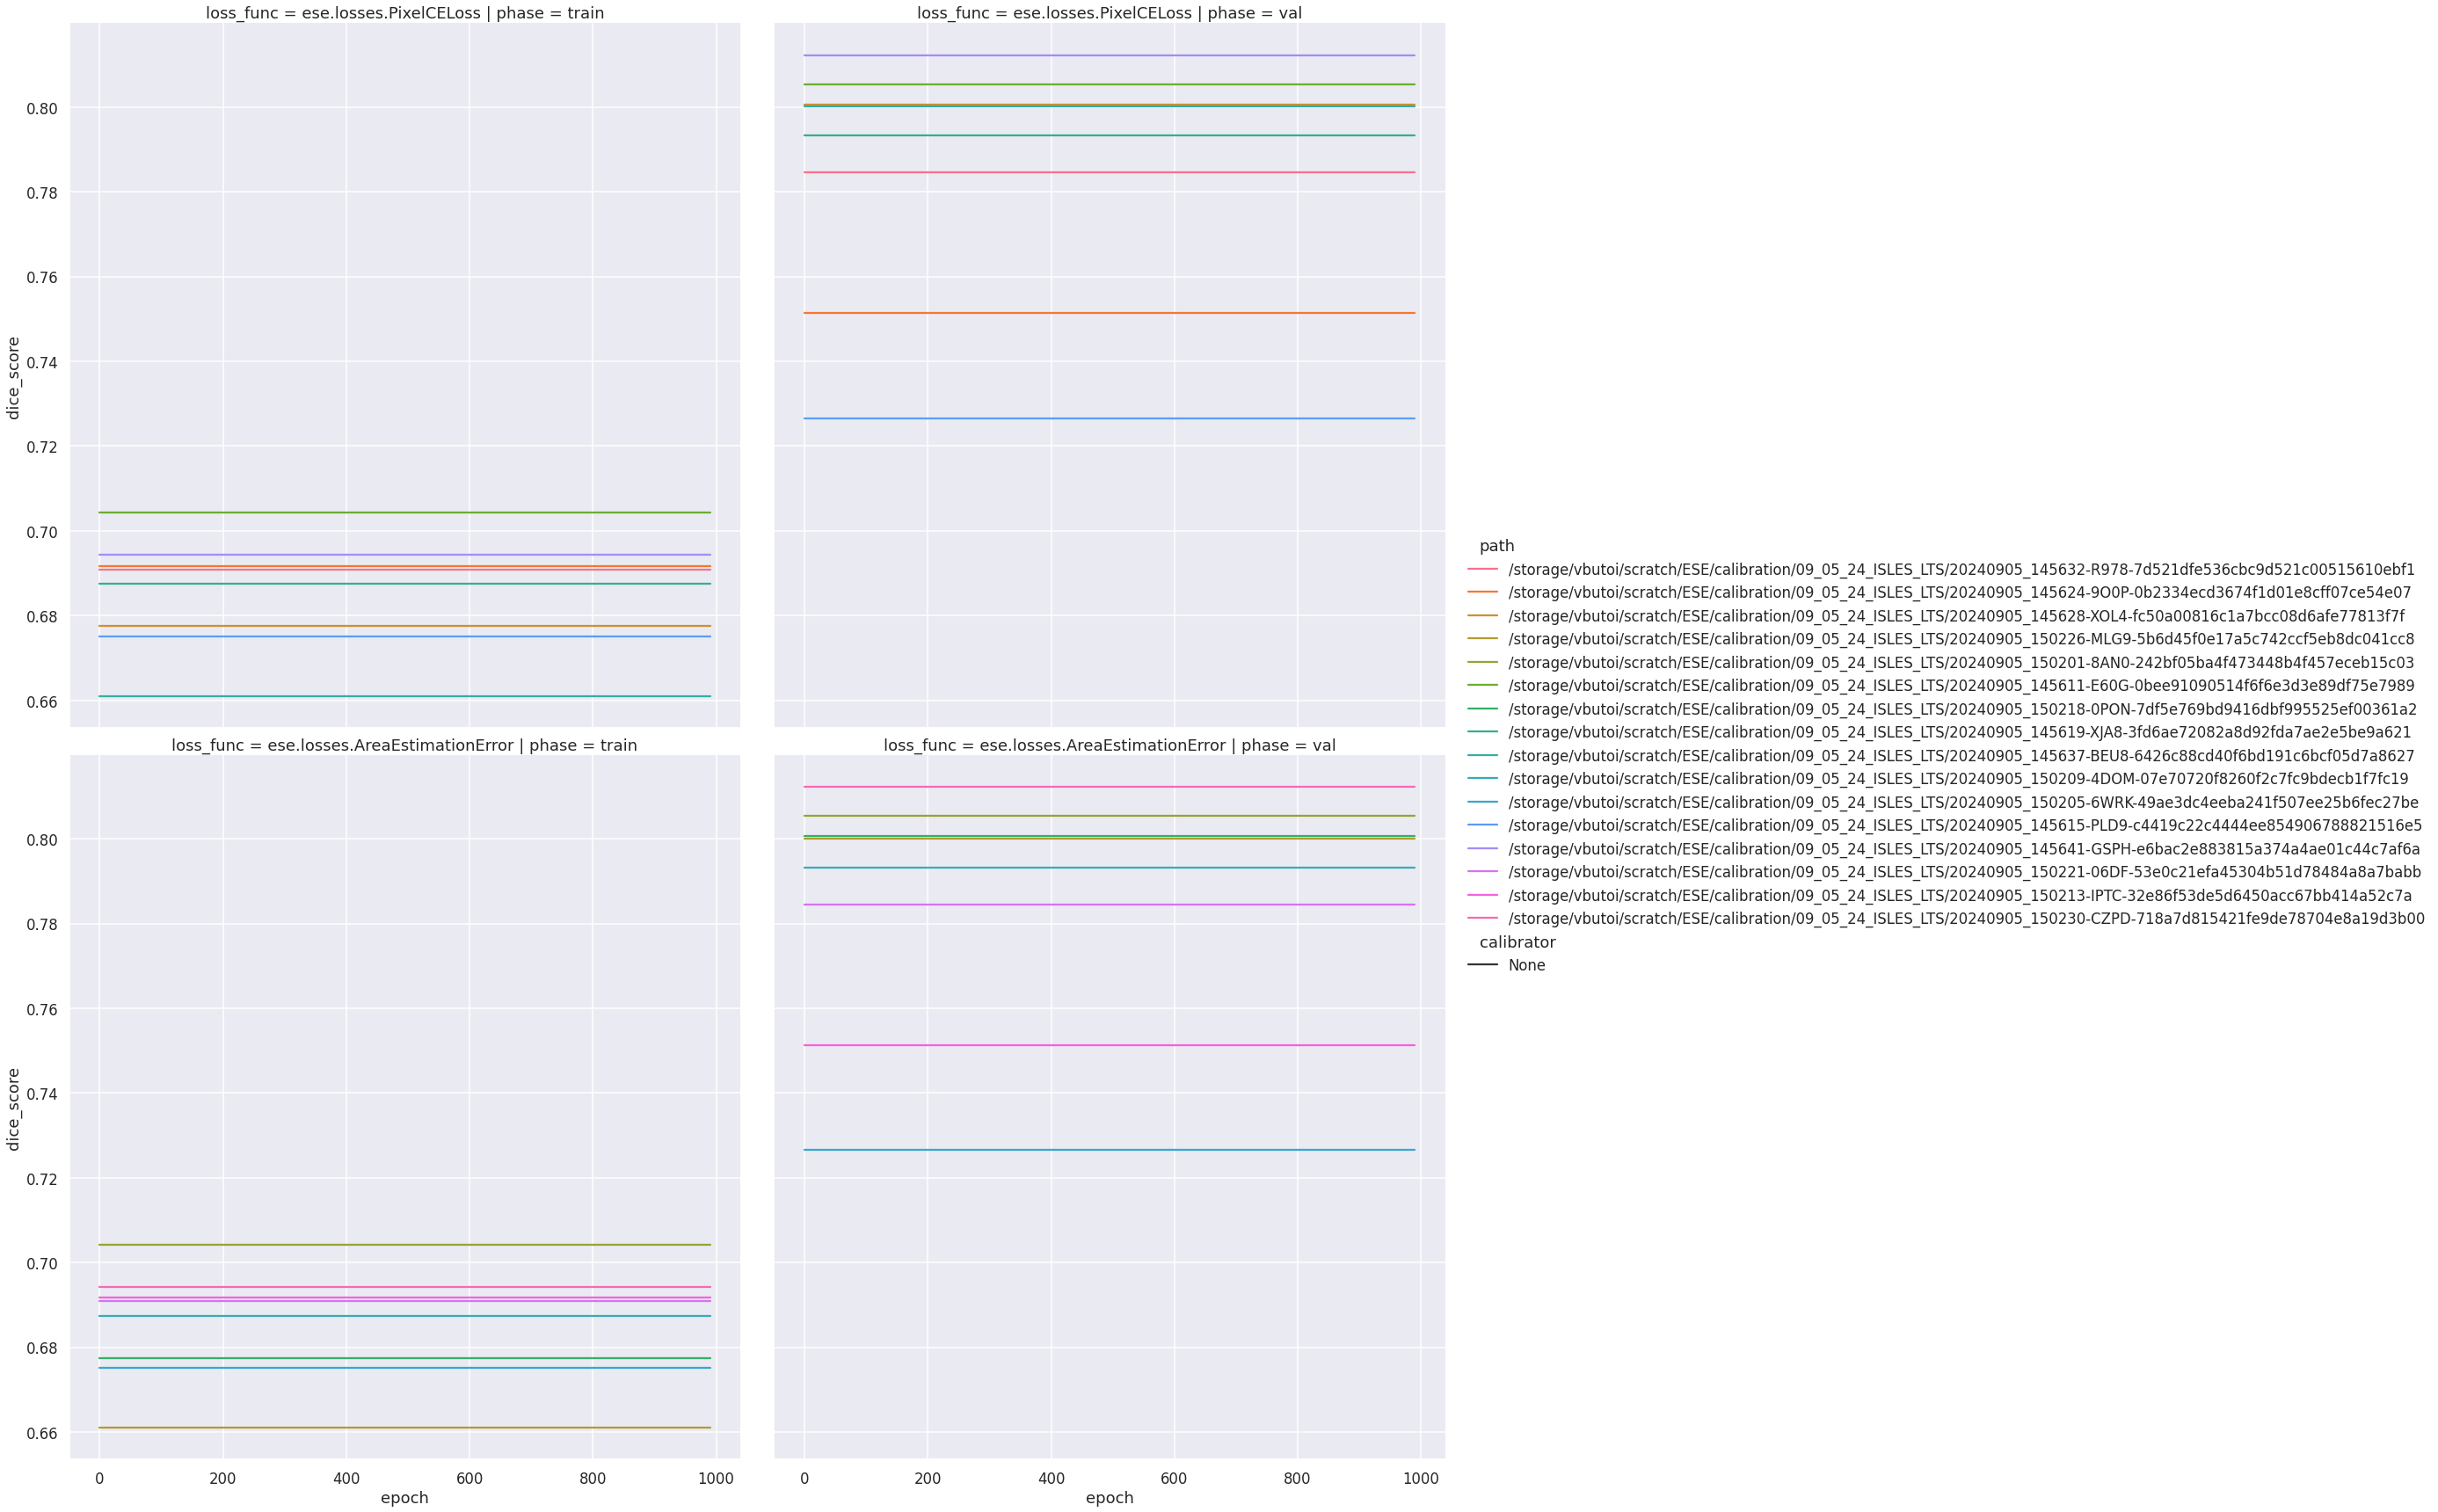

In [9]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='dice_score',
    hue='path',
    # hue='seed',
    style='calibrator',
    row='loss_func',   
    col='phase',
    kind='line',
    height=12,
    # palette=custom_palette
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.05)
# g.set(ylim=(0.0, 0.25))

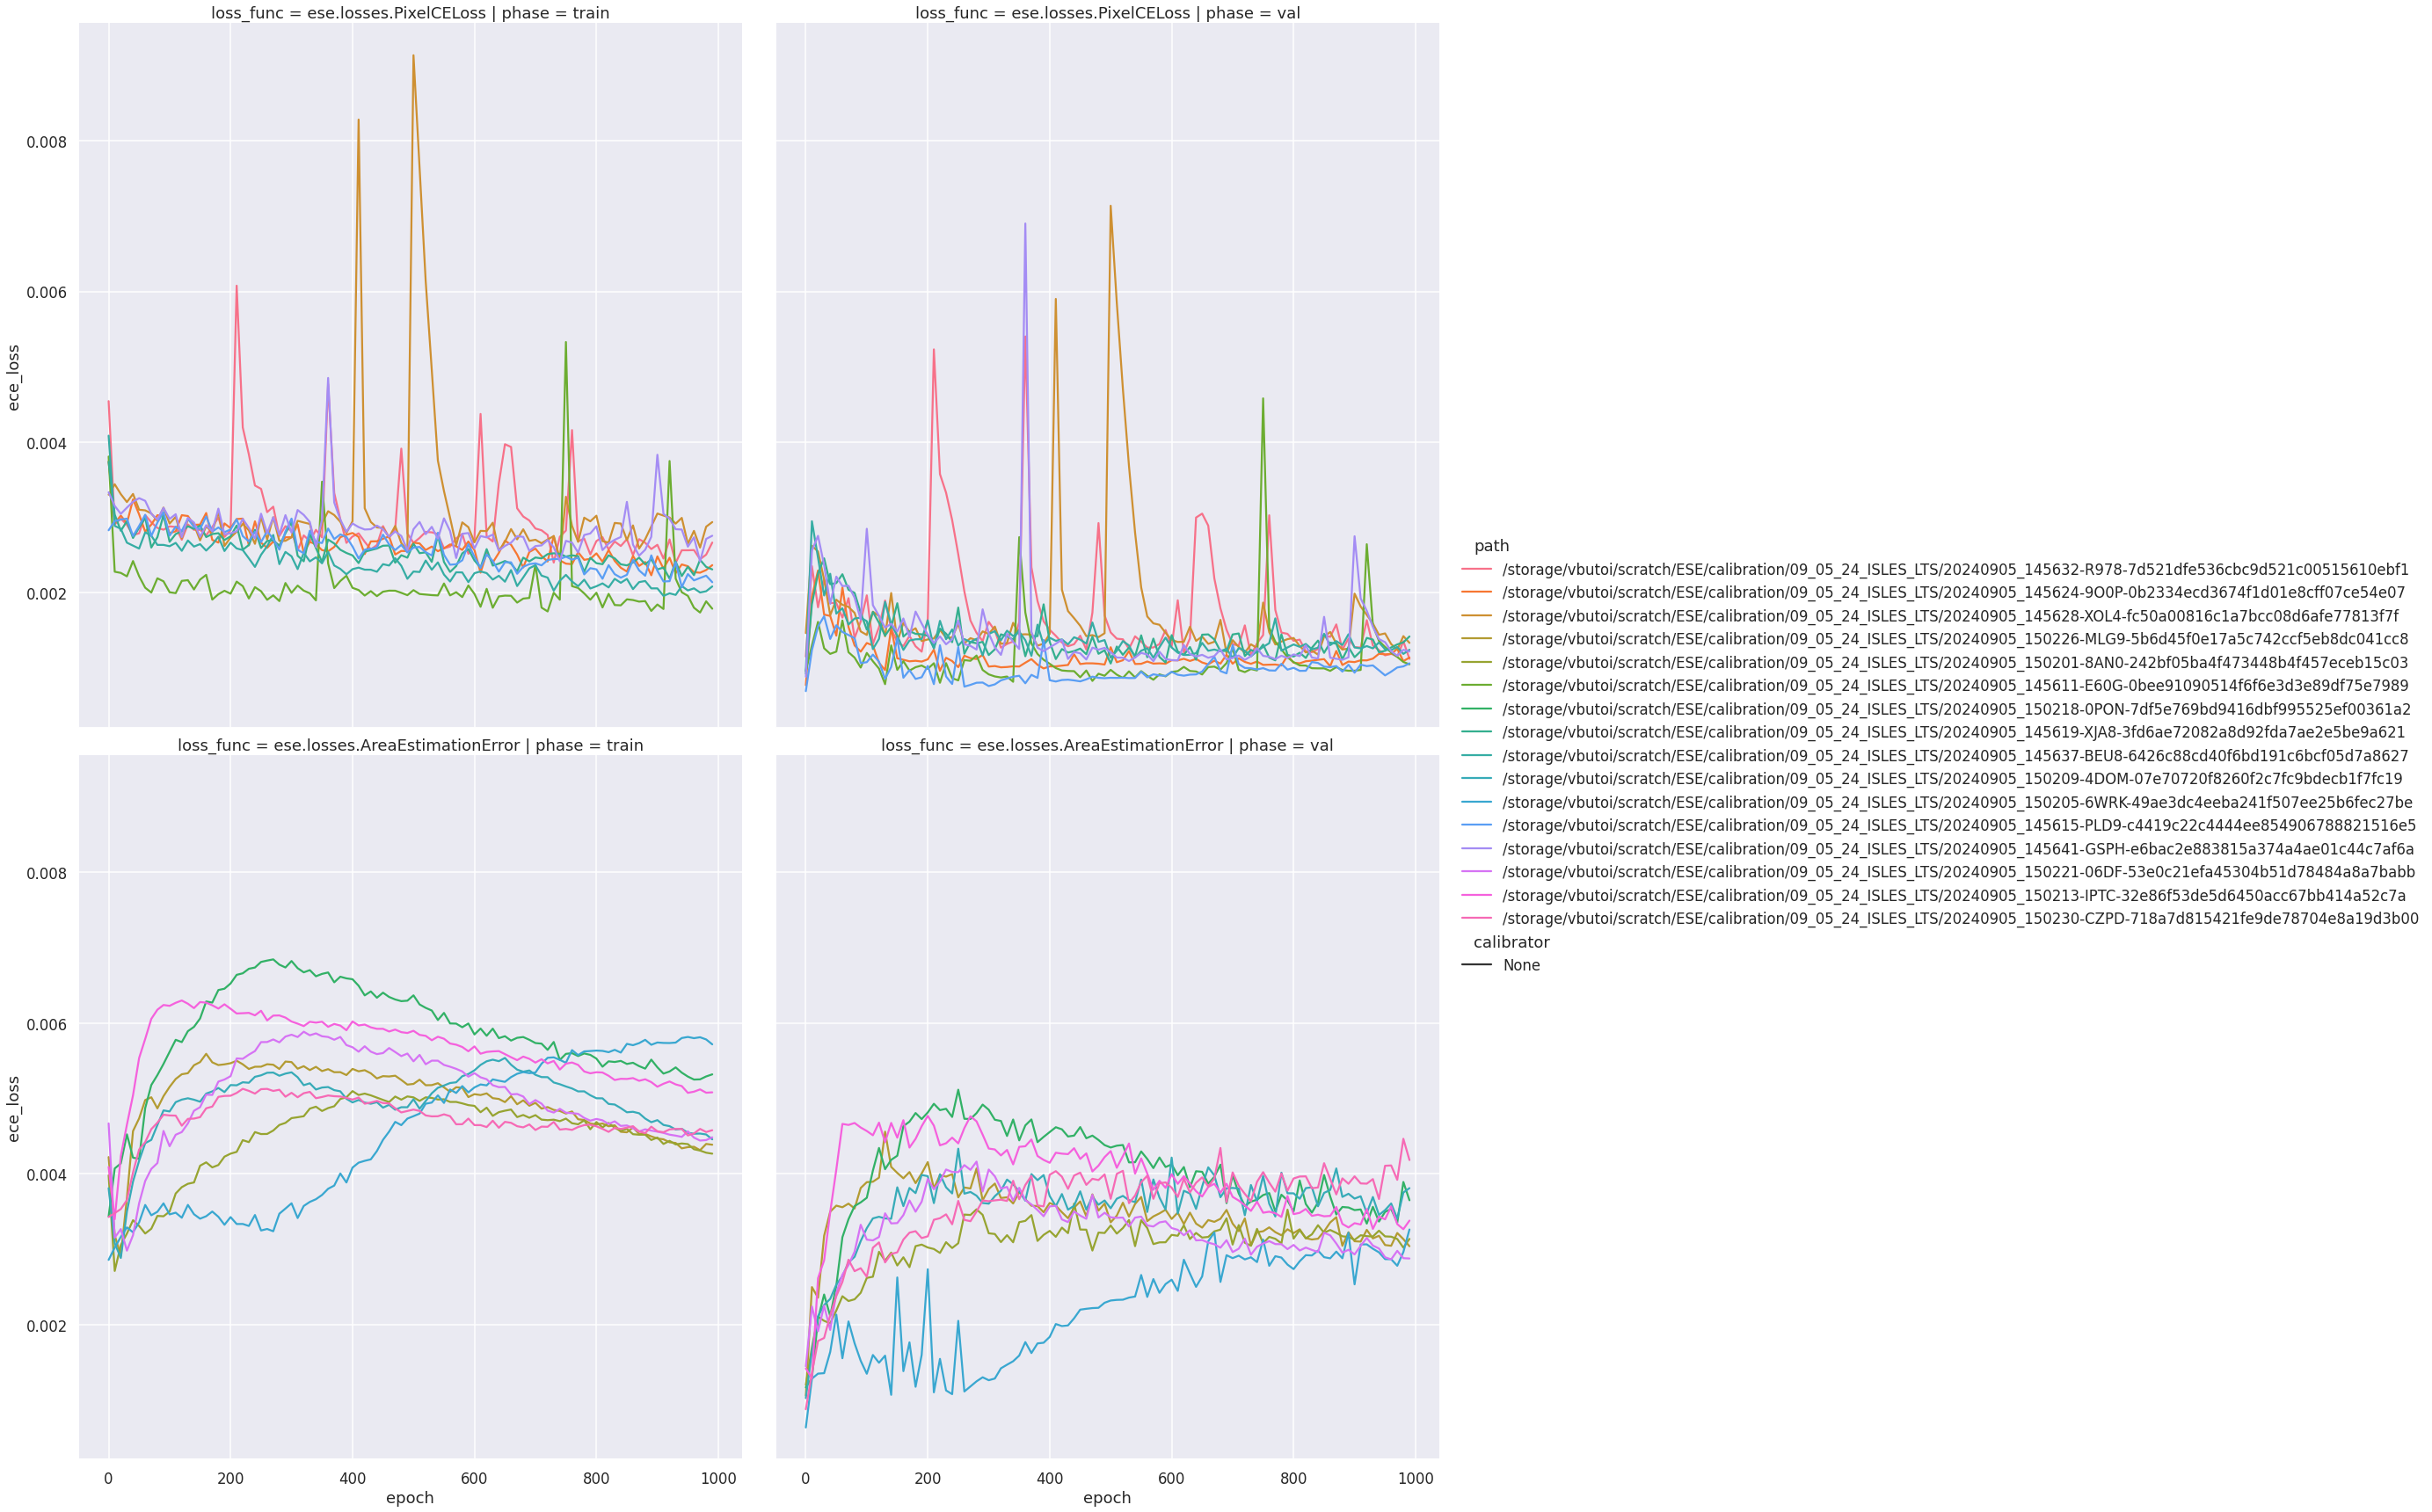

In [10]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='ece_loss',
    hue='path',
    # hue='seed',
    style='calibrator',
    row='loss_func',   
    col='phase',
    kind='line',
    height=12,
    # palette=custom_palette
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.05)
# g.set(ylim=(0.0, 0.25))

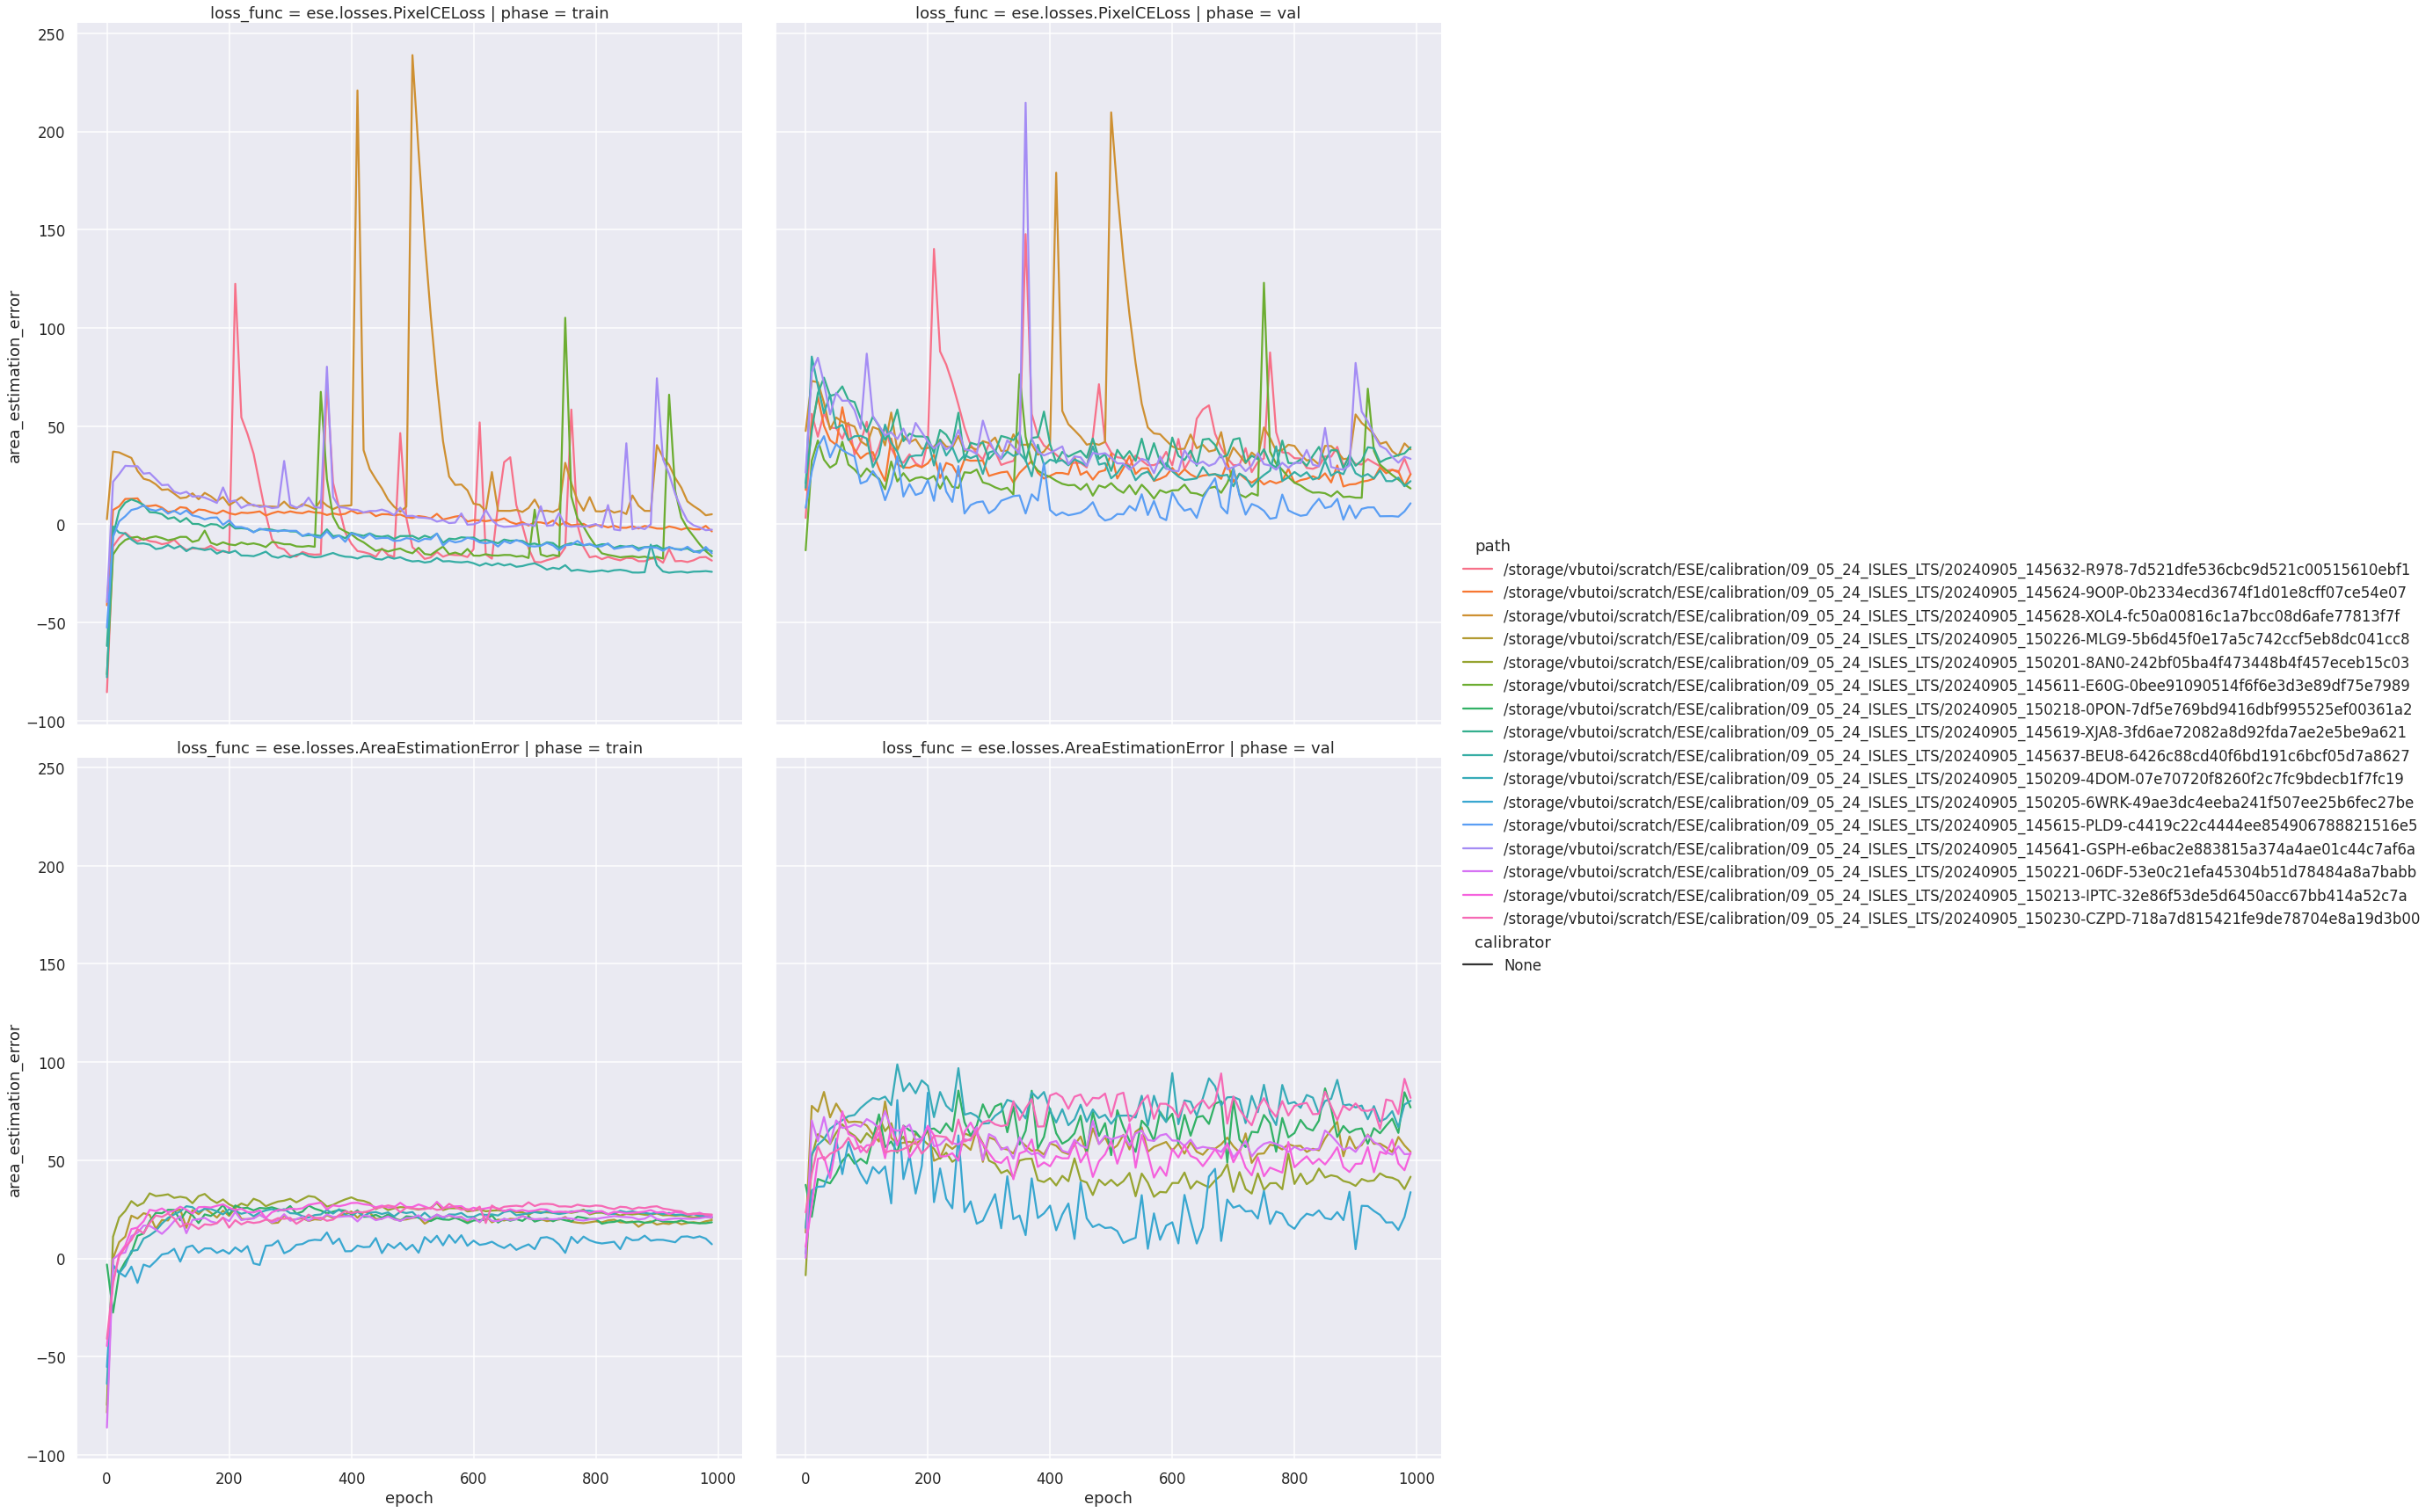

In [11]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='area_estimation_error',
    hue='path',
    # hue='seed',
    style='calibrator',
    row='loss_func',   
    col='phase',
    kind='line',
    height=12,
    # palette=custom_palette
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.05)
# g.set(ylim=(0.0, 0.25))